In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from scipy.stats import linregress
import statsmodels.api as sm


# Import API key
import json
from api_keys import Nasdaq_API_Key

In [2]:
# Defined the file paths and read the CSV files into pandas DataFrames

interest_rates = pd.read_csv("Resources/interest_rates.csv")
median_sales_df = pd.read_csv("Resources/median_sale.csv")
home_value_df = pd.read_csv("Resources/Index_home_value.csv")


In [4]:
interest_rates["DATE"] = pd.to_datetime(interest_rates["DATE"])
interest_rates["DATE"] = interest_rates["DATE"].dt.strftime("%m/%Y")
interest_rates.insert(0, "DATE", interest_rates.pop("DATE"))
interest_rates.rename(columns={"DATE": "Date"}, inplace=True)
interest_rates.head()

,Date,MORTGAGE30US
0,08/2018,4.5500
1,09/2018,4.6275
2,10/2018,4.8300
3,11/2018,4.8660
4,12/2018,4.6375


In [5]:
# Filter the DataFrame for "New York, NY" and "Houston, TX" and filtering by 2018-08-31 to keep data consistent
#This portion of the code filters as of 8/31/2018, filters by city, and uses the Index_home_value
cities_home_value = home_value_df.loc[home_value_df["RegionName"].isin(["New York, NY", "Dallas, TX", "Houston, TX", "San Antonio, TX", "Austin, TX"])]

start_date_idx = cities_home_value.columns.get_loc("8/31/2018")
cities_home_value = cities_home_value[["RegionName"]].join(cities_home_value.iloc[:, start_date_idx:])
cities_home_value.head(6)

,RegionName,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,...,9/30/2022,10/31/2022,11/30/2022,12/31/2022,1/31/2023,2/28/2023,3/31/2023,4/30/2023,5/31/2023,6/30/2023
1,"New York, NY",453849.3071,456122.7965,457268.8105,457976.4653,458217.3809,459451.7481,461677.6102,464645.0390,467649.5841,...,602170.4666,599983.2915,598149.1058,595670.3379,595634.6335,596861.4192,600803.8242,603913.5044,608086.7862,613275.8207
4,"Dallas, TX",255322.8157,256089.6958,256535.8629,257036.9940,257762.0274,258739.1867,259829.5997,260818.2839,261442.9355,...,387026.6062,384909.0112,382969.8995,380395.3382,377771.1224,375643.7088,374907.5328,374561.8430,374973.0538,376025.5121
5,"Houston, TX",211560.0399,212375.3596,213058.0958,213829.4405,214664.9824,215538.6103,216439.7394,217310.4799,217971.3204,...,310543.8296,309925.0131,309250.0062,307868.0724,306261.0530,305056.4655,305030.6054,305236.9000,305697.9226,306423.1477
24,"San Antonio, TX",197329.9016,198023.9341,198605.3597,199300.8476,200185.2082,201021.6494,201656.7150,202107.6121,202510.3674,...,298904.1866,297874.3085,296999.6989,295617.7809,294440.5075,293720.0927,294212.2925,294428.3722,294643.5995,294966.6295
29,"Austin, TX",317100.1049,317954.4660,318729.8712,319725.8688,320874.5245,321695.7024,322352.3195,322892.2047,323484.0068,...,532553.6958,524750.7822,517129.7411,509081.7476,501930.2802,496333.9588,493055.8511,490415.0852,488545.6731,487536.6227


In [6]:

def plot_cities_data(data_df, city1_name, city2_name, city3_name, city4_name, city5_name, y_label, title):
    plt.figure(figsize=(12, 12))  

    # First subplot: Median Sales Data
    plt.subplot(2, 1, 1)
    # Plots the data for each city as a line graph
    plt.plot(data_df.columns[6:], data_df[data_df["RegionName"] == city1_name].iloc[0, 6:].values, label=city1_name)
    plt.plot(data_df.columns[6:], data_df[data_df["RegionName"] == city2_name].iloc[0, 6:].values, label=city2_name)
    plt.plot(data_df.columns[6:], data_df[data_df["RegionName"] == city3_name].iloc[0, 6:].values, label=city3_name)
    plt.plot(data_df.columns[6:], data_df[data_df["RegionName"] == city4_name].iloc[0, 6:].values, label=city4_name)
    plt.plot(data_df.columns[6:], data_df[data_df["RegionName"] == city5_name].iloc[0, 6:].values, label=city5_name)

    # Adds labels and titles
    plt.xlabel("Date")
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()

    # Rotates the x-axis tick labels diagonally
    plt.xticks(rotation=45, ha="right", fontsize=8)

    # Second subplot: Relative Strength Index (RSI) Data
    plt.subplot(2, 1, 2)
    # Calculates RSI for each city's median sales data
    rsi_period = 14  # Defines the period for RSI calculation
    for city in [city1_name, city2_name, city3_name, city4_name, city5_name]:
        city_data = data_df[data_df["RegionName"] == city].iloc[0, 6:]
        delta = city_data.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=rsi_period).mean()
        avg_loss = loss.rolling(window=rsi_period).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))

        # Plots RSI values on the graph
        plt.plot(data_df.columns[6:], rsi, label=f"{city} RSI")
        plt.xticks(rotation=45, ha="right", fontsize=8)
        # Marks overbought (RSI > 70) and oversold (RSI < 30) regions with horizontal lines
        plt.axhline(70, color='r', linestyle='--', alpha=0.5)
        plt.axhline(30, color='g', linestyle='--', alpha=0.5)

    # Adds labels and titles for the second subplot
    plt.xlabel("Date")
    plt.ylabel("RSI")
    plt.title("Relative Strength Index (RSI)")
    plt.legend()

    plt.tight_layout()  
    plt.show()



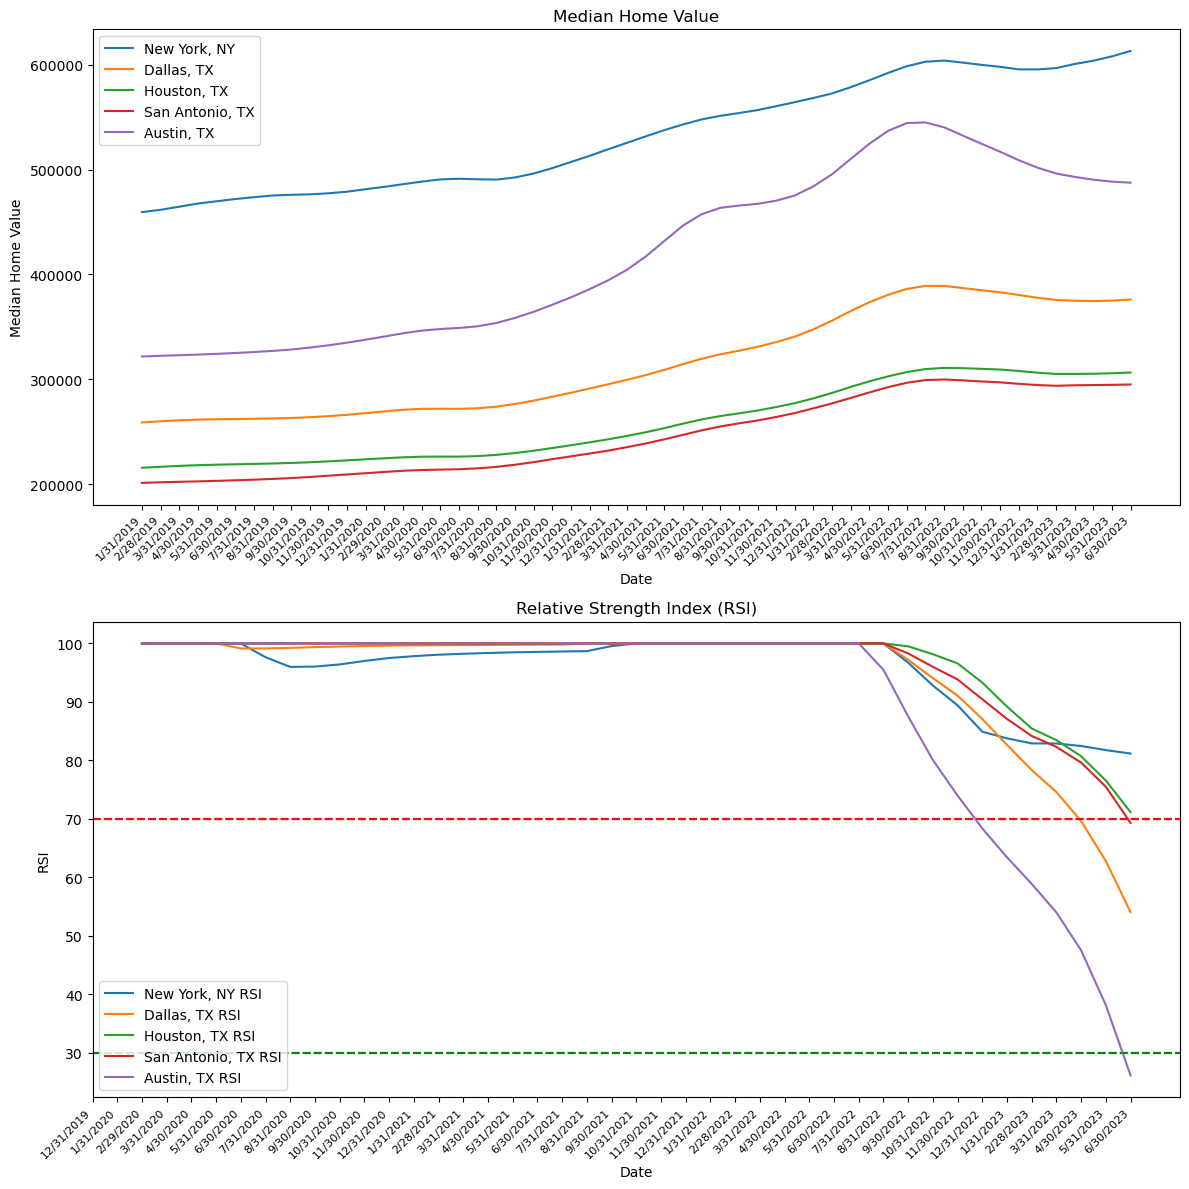

In [7]:
plot_cities_data(cities_home_value,"New York, NY", "Dallas, TX", "Houston, TX", "San Antonio, TX", "Austin, TX", "Median Home Value", "Median Home Value")


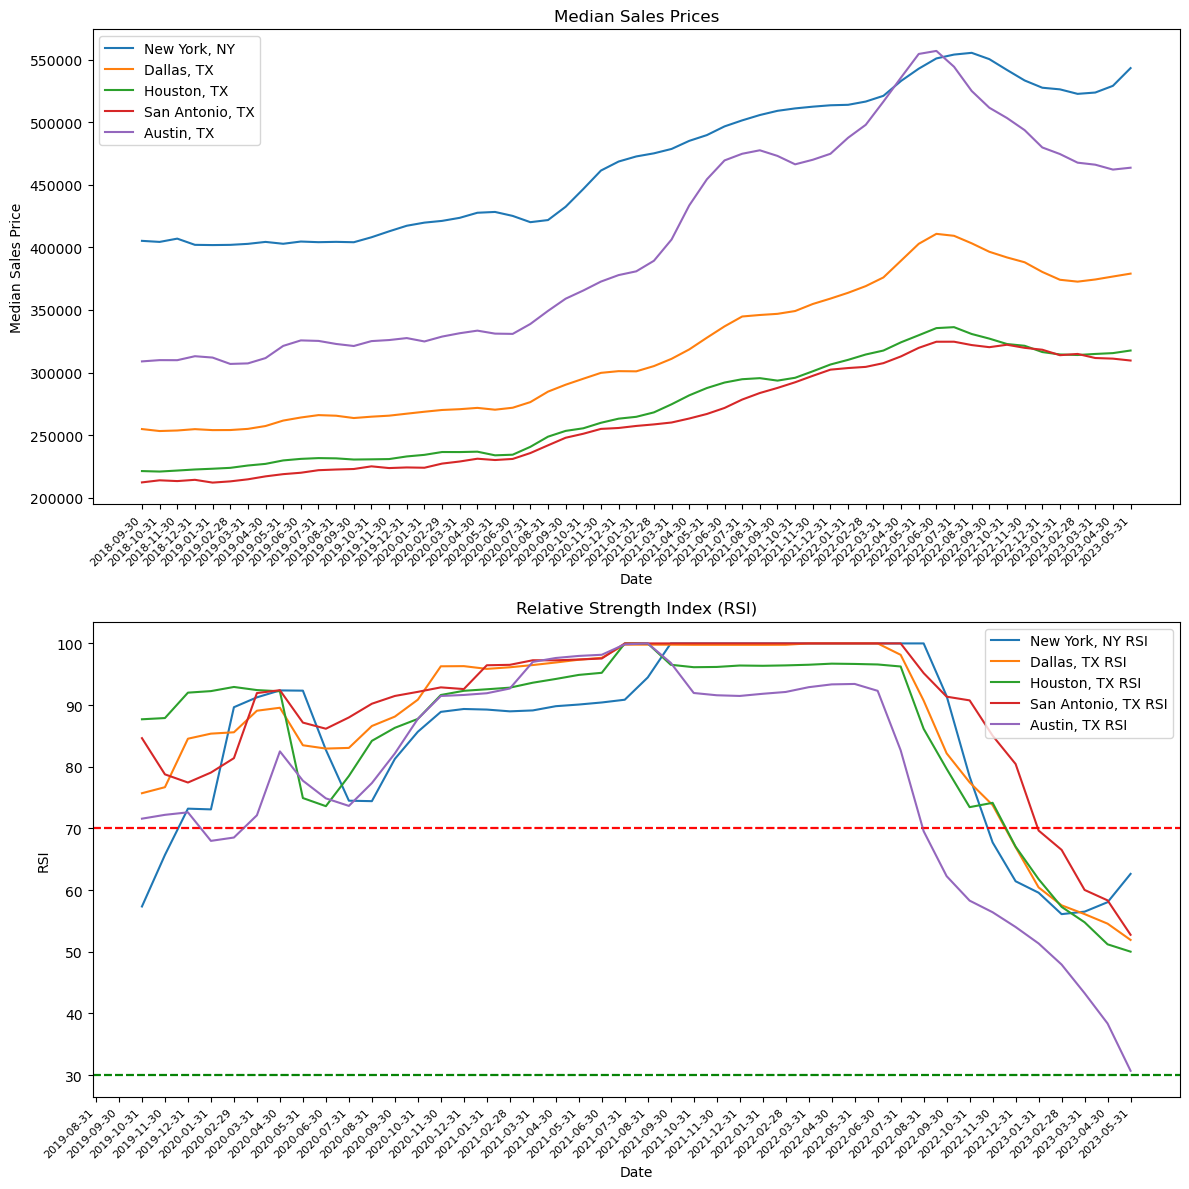

In [10]:
plot_cities_data(median_sales_df, "New York, NY", "Dallas, TX", "Houston, TX", "San Antonio, TX", "Austin, TX", y_label="Median Sales Price", title="Median Sales Prices")


In [11]:
# set up Houston home value 
houston_home_value = home_value_df.loc[home_value_df["RegionName"].isin(["Houston, TX"])]

start_date_idx = houston_home_value.columns.get_loc("8/31/2018")
houston_home_value = houston_home_value[["RegionName"]].join(houston_home_value.iloc[:, start_date_idx:])



In [12]:
houston_home_value_trans = houston_home_value.set_index("RegionName").transpose()
houston_home_value_trans = houston_home_value_trans.reset_index(drop = False)
houston_home_value_trans.rename(columns={"index": "Date"}, inplace = True)

houston_home_value_trans.tail()

RegionName,Date,"Houston, TX"
54,2/28/2023,305056.4655
55,3/31/2023,305030.6054
56,4/30/2023,305236.9000
57,5/31/2023,305697.9226
58,6/30/2023,306423.1477


In [13]:
houston_home_value_trans["Date"] = pd.to_datetime(houston_home_value_trans["Date"])

# Extract only the month and year from the date
houston_home_value_trans["Date"] = houston_home_value_trans["Date"].dt.strftime("%m/%Y")

# Insert the "Date" column at the first position
houston_home_value_trans.insert(0, "Date", houston_home_value_trans.pop("Date"))

houston_home_value_trans.head()


RegionName,Date,"Houston, TX"
0,08/2018,211560.0399
1,09/2018,212375.3596
2,10/2018,213058.0958
3,11/2018,213829.4405
4,12/2018,214664.9824


In [14]:
merged_df = pd.merge(houston_home_value_trans[["Date", "Houston, TX"]], interest_rates[["Date", "MORTGAGE30US"]], left_on="Date", right_on="Date")

merged_df.head()

,Date,"Houston, TX",MORTGAGE30US
0,08/2018,211560.0399,4.5500
1,09/2018,212375.3596,4.6275
2,10/2018,213058.0958,4.8300
3,11/2018,213829.4405,4.8660
4,12/2018,214664.9824,4.6375


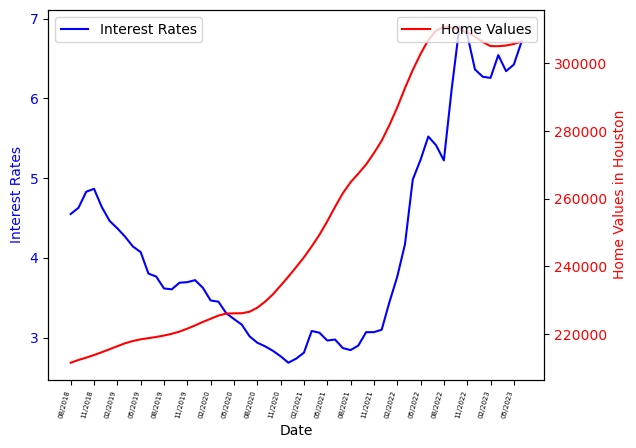

In [15]:

fig, ax1 = plt.subplots()

# Plots the interest rates on the primary y-axis
ax1.plot(merged_df["Date"], merged_df["MORTGAGE30US"], color='b', label="Interest Rates")
ax1.set_xlabel("Date")
ax1.set_ylabel("Interest Rates", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Sets the tick positions and labels for the x-axis
tick_positions = range(0, len(merged_df["Date"]), 3)  # Assuming you want ticks every 30 days
tick_labels = merged_df["Date"].iloc[tick_positions]
ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels, rotation=75, ha="right", fontsize=5)

# Creates a secondary y-axis
ax2 = ax1.twinx()

# Plots the Houston, TX data on the secondary y-axis as a line plot
ax2.plot(merged_df["Date"], merged_df["Houston, TX"], color='r', label="Home Values")

# Sets the label for the secondary y-axis
ax2.set_ylabel("Home Values in Houston", color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Displays the legend for both plots
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()
